In [1]:
import pandas as pd
import numpy as np
import subprocess
import random
import pipeline_script
import seaborn as sns
import math
from tqdm import tqdm
import re
import matplotlib.pyplot as plt
from numpy.random import RandomState
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
import os
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder

Import Processed Participant DF

In [2]:
participant_df = pd.read_csv("participant_info_processed.csv",index_col="SID")
participant_df.head()

,AGE,GENDER,BMI,OAHI,AHI,Mean_SaO2,Arousal Index,MEDICAL_HISTORY,Sleep_Disorders,asthma,...,eds,rbd,hypersomnia,grind teeth,insomnia,fatigue,morning headaches,bruxism,snore,headache
SID,,,,,,,,,,,,,,,,,,,,,
S002,0.679909,1,0.166667,19,19,91%,98,"Asthma, Body Pain, GERD, Hypertension, Sleep A...",OSA,0,...,0,0,0,0,0,0,0,0,0,0
S003,0.124049,0,0.611111,34,37,95%,28,NaN,"snoring, sleep apnea, difficulty breathing, sn...",0,...,0,0,0,0,0,0,0,0,0,0
S004,0.524049,0,0.425926,63,99,89%,109,"Arrhythmia, Body Pain, Depression, Dyspnea, GERD",difficulty breathing,0,...,0,0,0,0,0,0,0,0,0,0
S005,0.424505,0,0.462963,19,20,95%,28,"Asthma, Body Pain, Depression, Diabetes, Dyspn...",OSA,0,...,0,0,0,0,0,0,0,0,0,0
S006,0.238661,0,0.074074,4,5,97%,34,"Depression, Sleep Apnea",OSA,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
patient_records = pipeline_script.gather_dict("normalized_data_20",False)

100%|██████████| 98/98 [00:18<00:00,  5.41it/s]


In [4]:
patient_records["S002"].dtypes

Unnamed: 0                             int64
TIMESTAMP                            float64
BVP                                  float64
ACC_X                                float64
ACC_Y                                float64
ACC_Z                                float64
TEMP                                 float64
EDA                                  float64
HR                                   float64
IBI                                  float64
IBI_Moving_Average_640               float64
IBI_Moving_STD_640                   float64
ACC                                  float64
Abnormal_IBI_Moving_4_Mean_Scaled    float64
HR_Divided_Mean                      float64
HR_Divided_Median                    float64
Sleep_Stage                           object
dtype: object

Specify The Columns To Use In Training And Prediction

In [4]:
patient_records["S002"].head(1).columns

Index(['Unnamed: 0', 'TIMESTAMP', 'BVP', 'ACC_X', 'ACC_Y', 'ACC_Z', 'TEMP',
       'EDA', 'HR', 'IBI', 'IBI_Moving_Average_640', 'IBI_Moving_STD_640',
       'ACC', 'Abnormal_IBI_Moving_4_Mean_Scaled', 'HR_Divided_Mean',
       'HR_Divided_Median', 'Sleep_Stage'],
      dtype='object')

In [5]:
columns = [ 'BVP', 'ACC_X', 'ACC_Y', 'ACC_Z', 'TEMP', 'EDA', 'HR',
       'IBI',
       'Multiple_Events', 'IBI_Moving_Average_640', 'IBI_Moving_STD_640',
       'Abnormal_IBI_Moving_3', 'Abnormal_IBI_Moving_4', 'ACC',
       'HR_Divided_Mean', 'HR_Divided_Median',
       'Abnormal_IBI_Moving_4_Mean_Scaled']

In [5]:
participant_df.columns

Index(['AGE', 'GENDER', 'BMI', 'OAHI', 'AHI', 'Mean_SaO2', 'Arousal Index',
       'MEDICAL_HISTORY', 'Sleep_Disorders', 'asthma', 'body pain', 'gerd',
       'hypertension', 'sleep apnea', 'arrhythmia', 'depression', 'dyspnea',
       'diabetes', 'cad', 'anxiety', 'migraine', 'osa', 'snoring',
       'difficulty breathing', 'difficulty staying asleep', 'snort', 'rls',
       'eds', 'rbd', 'hypersomnia', 'grind teeth', 'insomnia', 'fatigue',
       'morning headaches', 'bruxism', 'snore', 'headache'],
      dtype='object')

In [6]:
columns_participant=['AGE', 'GENDER', 'BMI','asthma',
       'body pain', 'gerd', 'hypertension', 'sleep apnea', 'arrhythmia',
       'depression', 'dyspnea', 'diabetes', 'cad', 'anxiety', 'migraine',
       'osa', 'snoring', 'difficulty breathing', 'difficulty staying asleep',
       'snort', 'rls', 'eds', 'rbd', 'hypersomnia', 'grind teeth', 'insomnia',
       'fatigue', 'morning headaches', 'bruxism', 'snore', 'headache']

Dimensionality =

In [6]:
print(len(columns)+len(columns_participant))

48


Creating Model

Prepare test and train sets

In [7]:
rng = np.random.default_rng(seed = 40)
test_validation_indexes = rng.random(30)
a, b = 0, len(patient_records.keys())  # Example range
test_validation_indexes = np.floor(a + (b - a) * test_validation_indexes)
test_validation_indexes = [int(i) for i in test_validation_indexes]

validation_indexes = test_validation_indexes[:15]
test_indexes = test_validation_indexes[15:]
print(validation_indexes,test_indexes)

[71, 67, 92, 5, 67, 90, 46, 33, 58, 71, 11, 10, 62, 4, 4] [31, 20, 76, 78, 16, 13, 36, 51, 53, 37, 42, 35, 26, 60, 26]


In [10]:
a = patient_records["S002"]


In [8]:
train_set = {}
for i,v in tqdm(patient_records.items()):
    train_set[i] = v.loc[v["Sleep_Stage"]!="P"]
    #train_set[i].loc[v["Sleep_Stage"]!="W","Sleep_Stage"] = "A"
    for column in columns_participant:
        train_set[i].loc[:,column] = participant_df.loc[i,column]

  0%|          | 0/98 [00:00<?, ?it/s]C:\Users\alkan\AppData\Local\Temp\ipykernel_20936\2278165693.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set[i].loc[:,column] = participant_df.loc[i,column]
C:\Users\alkan\AppData\Local\Temp\ipykernel_20936\2278165693.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set[i].loc[:,column] = participant_df.loc[i,column]
C:\Users\alkan\AppData\Local\Temp\ipykernel_20936\2278165693.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of

In [40]:
train_set["S002"]["GENDER"]

29357     0
29358     0
29359     0
29360     0
29361     0
         ..
100680    0
100681    0
100682    0
100683    0
100684    0
Name: GENDER, Length: 71328, dtype: int64

In [48]:
list(train_set.keys())

['S002',
 'S003',
 'S004',
 'S005',
 'S006',
 'S007',
 'S008',
 'S009',
 'S010',
 'S011',
 'S012',
 'S013',
 'S014',
 'S015',
 'S016',
 'S017',
 'S018',
 'S019',
 'S020',
 'S021']

In [10]:
test_df = pd.DataFrame()
train_df = pd.DataFrame()

for i,key in tqdm(enumerate(list(patient_records.keys()))):
    if i in test_indexes or i in validation_indexes:
        test_df= pd.concat([test_df,train_set[key]],ignore_index=True)
    else:
        train_df= pd.concat([train_df,train_set[key]],ignore_index=True)


98it [00:33,  2.90it/s]


In [11]:
X_train, y_train = train_df.drop("Sleep_Stage",axis=1),train_df["Sleep_Stage"]

In [12]:
X_test, y_test = test_df.drop("Sleep_Stage",axis=1),test_df["Sleep_Stage"]

In [11]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [12]:
pd.set_option('display.max_columns', None)
X_train.head()

,Unnamed: 0,TIMESTAMP,BVP,ACC_X,ACC_Y,ACC_Z,TEMP,EDA,HR,IBI,IBI_Moving_Average_640,IBI_Moving_STD_640,ACC,Abnormal_IBI_Moving_4_Mean_Scaled,HR_Divided_Mean,HR_Divided_Median,AGE,GENDER,BMI,asthma,body pain,gerd,hypertension,sleep apnea,arrhythmia,depression,dyspnea,diabetes,cad,anxiety,migraine,osa,snoring,difficulty breathing,difficulty staying asleep,snort,rls,eds,rbd,hypersomnia,grind teeth,insomnia,fatigue,morning headaches,bruxism,snore,headache
0,29357,9174.210938,7.1840,-21.3,-61.5,6.3,32.09,0.065832,72.85,1.0625,0.962207,0.049798,65.466404,0.0,1.031933,1.086017,0.679909,1,0.166667,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,29358,9174.523438,-3.3475,-21.3,-61.4,6.0,32.09,0.065064,72.85,1.0625,0.966113,0.052540,65.279331,0.0,1.031933,1.086017,0.679909,1,0.166667,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,29359,9174.835938,-12.6025,-21.4,-61.5,5.3,32.09,0.065064,72.85,1.0625,0.970020,0.054868,65.335748,0.0,1.031933,1.086017,0.679909,1,0.166667,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,29360,9175.148438,-8.7865,-20.9,-61.7,5.5,32.11,0.065320,73.33,1.0625,0.973926,0.056832,65.381629,0.0,1.038732,1.093172,0.679909,1,0.166667,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,29361,9175.460938,-1.1710,-21.6,-61.3,5.3,32.11,0.065320,73.33,1.0625,0.977832,0.058470,65.213751,0.0,1.038732,1.093172,0.679909,1,0.166667,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [17]:
X_train.dtypes

TIMESTAMP                            float64
BVP                                  float64
ACC_X                                float64
ACC_Y                                float64
ACC_Z                                float64
TEMP                                 float64
EDA                                  float64
HR                                   float64
IBI                                  float64
IBI_Moving_Average_640               float64
IBI_Moving_STD_640                   float64
ACC                                  float64
HR_Divided_Mean                      float64
HR_Divided_Median                    float64
Abnormal_IBI_Moving_4_Mean_Scaled    float64
AGE                                  float64
GENDER                                 int64
BMI                                  float64
asthma                                 int64
body pain                              int64
gerd                                   int64
hypertension                           int64
sleep apne

### XGB Classifier

In [ ]:
model = xgb.XGBClassifier(
    n_estimators=10,  # Number of trees
    learning_rate=0.5,  # Step size shrinkage
    max_depth=3,  # Maximum depth of a tree
    random_state=42,  # For reproducibility
)

# Train the model
model.fit(X_train, y_train_encoded) 

In [17]:
# Make predictions
y_pred = model.predict(X_test)
acc = accuracy_score(y_test_encoded, y_pred)
f1,pre,rec = f1_score(y_test_encoded, y_pred,average="macro"),precision_score(y_test_encoded, y_pred,average="macro"),recall_score(y_test_encoded, y_pred,average="macro")
acc,f1,pre,rec

(0.48620972292237746,
 0.20651008687164762,
 0.20116412704327855,
 0.23979102253654427)

In [50]:
label_encoder.inverse_transform([0, 1, 2, 3, 4])

array(['N1', 'N2', 'N3', 'R', 'W'], dtype=object)

In [49]:
np.unique(y_pred,return_counts=True)

(array([0, 1, 2, 3, 4]), array([ 132823, 2162569,   31325,  179003, 1169550]))

In [48]:
confusion_matrix(y_test_encoded,y_pred)


array([[  17398,  186565,    4120,   16868,   82825],
       [  68827, 1236922,   17001,   81571,  555617],
       [   2267,  117529,     769,    7661,   58590],
       [  16571,  282019,    4539,   28516,  103428],
       [  27760,  339534,    4896,   44387,  369090]])

In [52]:
precision_per_class = precision_score(y_test_encoded, y_pred, average=None)
precision_per_class

array([0.13098635, 0.5719688 , 0.02454908, 0.15930459, 0.31558292])

In [21]:
y_test

0           W
1           W
2           W
3           W
4           W
           ..
3675265    N2
3675266    N2
3675267    N2
3675268    N2
3675269    N2
Name: Sleep_Stage, Length: 3675270, dtype: object

In [22]:
y_pred

array([1, 1, 1, ..., 1, 1, 1], shape=(3675270,))

In [23]:
np.unique(y_test_encoded,return_counts=True)

(array([0, 1, 2, 3, 4]), array([ 307776, 1959938,  186816,  435073,  785667]))

In [33]:
np.unique(y_pred,return_counts=True)

(array([0, 1, 2, 3, 4]), array([  28725, 2437030,    5970,   47165, 1156380]))

In [25]:
label_encoder.inverse_transform([0,1])

array(['N1', 'N2'], dtype=object)

In [18]:
len(X_train.columns)

48

### Applying PCA to fasten the SMOTE process

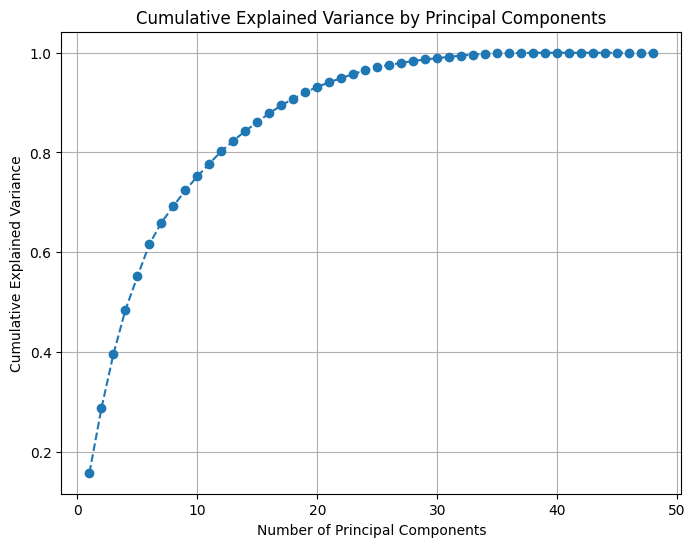

Cumulative Explained Variance: [0.15807673 0.28733636 0.39586632 0.48442213 0.55161987 0.61618546
 0.6595253  0.69251057 0.72433265 0.75205644 0.77790576 0.80245303
 0.82372714 0.8431206  0.86104303 0.87876312 0.89453937 0.90784416
 0.92035398 0.93156177 0.940699   0.94924262 0.95733152 0.96480897
 0.97100469 0.97550238 0.9796115  0.98347284 0.98643658 0.98911419
 0.99172775 0.99424593 0.99609451 0.99778108 0.99868382 0.99926059
 0.99964576 0.99990172 0.99994314 0.9999732  0.99998883 1.
 1.         1.         1.         1.         1.         1.        ]


In [20]:
pca = PCA(n_components=X_train.shape[1])  
pca.fit(X_train)

cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(8, 6))
plt.plot(range(1, X_train.shape[1] + 1), cumulative_variance, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by Principal Components')
plt.grid(True)
plt.show()

print("Cumulative Explained Variance:", cumulative_variance)

In [12]:
pca = PCA(n_components=20)  # Reduce to 20 principal components
X_pca = pca.fit_transform(X_train)

In [14]:
import joblib

In [13]:
X_test_pca = pca.transform(X_test)

In [15]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42,sampling_strategy = {0: 628034*3, 1: 2829313, 2: 156480*5,3: 573410*3,4: 1342855})

In [17]:
joblib.dump(pca,"pca.joblib")

['pca.joblib']

In [14]:
np.unique_counts(y_train_encoded)

UniqueCountsResult(values=array([0, 1, 2, 3, 4]), counts=array([ 628034, 2829313,  156480,  573410, 1342855]))

In [17]:
n = len(y_train_encoded)

In [18]:
X_resampled, y_resampled = smote.fit_resample(X_train[:n], y_train_encoded[:n])

c:\Users\alkan\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] Sistem belirtilen dosyayı bulamıyor
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\alkan\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\alkan\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 546, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\alkan\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 1022, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "

In [19]:
np.save("X_resampled.npy", X_resampled)
np.save("y_resampled.npy", y_resampled)

In [ ]:
model = xgb.XGBClassifier(
    n_estimators=100,  # Number of trees
    learning_rate=0.1,  # Step size shrinkage
    max_depth=3,  # Maximum depth of a tree
    random_state=42,  # For reproducibility
    use_label_encoder=False  # Avoid warning in recent XGBoost versions
)

# Train the model
model.fit(X_resampled, y_resampled)

In [52]:
y_pred = model.predict(X_test_pca)

In [53]:
acc = accuracy_score(y_test_encoded, y_pred)
f1,pre,rec = f1_score(y_test_encoded, y_pred,average="macro"),precision_score(y_test_encoded, y_pred,average="macro"),recall_score(y_test_encoded, y_pred,average="macro")
print(acc,f1,pre,rec)

0.25932734193678286 0.23706437599776553 0.2652951824458047 0.2786513183900019


In [56]:
confusion_matrix(y_test_encoded,y_pred)

array([[ 38178,  50719,  13514,  84608, 120757],
       [251837, 364015, 102863, 422662, 818561],
       [     0,  26872,  59463,  10238,  90243],
       [ 78821,  82013,  21626, 136183, 116430],
       [114506,  86805,  37122, 191975, 355259]])

In [54]:
import joblib
joblib.dump(model, "xgb_model_1.pkl")

['xgb_model_1.pkl']

In [57]:
model = xgb.XGBClassifier(
    n_estimators=100,  # Number of trees
    learning_rate=0.1,  # Step size shrinkage
    max_depth=3,  # Maximum depth of a tree
    random_state=42,  # For reproducibility
    use_label_encoder=False  # Avoid warning in recent XGBoost versions
)

# Train the model
model.fit(X_pca, y_train_encoded)
y_pred_pca = model.predict(X_test_pca)
acc = accuracy_score(y_test_encoded, y_pred_pca)
f1,pre,rec = f1_score(y_test_encoded, y_pred_pca,average="macro"),precision_score(y_test_encoded, y_pred_pca,average="macro"),recall_score(y_test_encoded, y_pred_pca,average="macro")
print(acc,f1,pre,rec)

c:\Users\alkan\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:51:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\alkan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0.46476340513758174 0.17646577101829702 0.15729587554883218 0.2053191442538759


### Random FOrest Classifier

In [15]:
rf_classifier = RandomForestClassifier(n_estimators=1, random_state=30,max_depth=48)

In [18]:
list = []
for i in tqdm(range(1, 6)):  # Adding 5 more iterations of trees (total 50)
    rf_classifier.n_estimators += 5  # Add 10 trees at each iteration
    rf_classifier.fit(X_train,y_train)  # Fit the model with the updated number of trees
    y_pred = rf_classifier.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1,pre,rec = f1_score(y_test, y_pred,average="macro"),precision_score(y_test, y_pred,average="macro"),recall_score(y_test, y_pred,average="macro")
    list.append([acc,f1,pre,rec])

100%|██████████| 5/5 [30:17<00:00, 363.59s/it]


In [20]:
print(np.array(list))

[[0.36448454 0.20269397 0.24076961 0.23198806]
 [0.37352823 0.19804084 0.22417373 0.23052211]
 [0.37260498 0.18977093 0.21358202 0.22659607]
 [0.3819155  0.19157428 0.20908913 0.23140149]
 [0.37556355 0.18702661 0.22029659 0.22924702]]
